In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

In [ ]:
sdir = '/content/drive/MyDrive/XrayKneeOsteoarthritis'
image_size = (224, 224)
batch_size = 64
k_folds = 5

In [ ]:
filepaths=[]
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                                           filepaths labels
0  /content/drive/MyDrive/XrayKneeOsteoarthritis/...      0
1  /content/drive/MyDrive/XrayKneeOsteoarthritis/...      0
2  /content/drive/MyDrive/XrayKneeOsteoarthritis/...      0
3  /content/drive/MyDrive/XrayKneeOsteoarthritis/...      0
4  /content/drive/MyDrive/XrayKneeOsteoarthritis/...      0
labels
0    3798
2    2545
4    1790
1    1749
3    1281
Name: count, dtype: int64


In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['labels'], random_state=42)

print(train_df['labels'].value_counts())
print(test_df['labels'].value_counts())

labels
0    3038
2    2036
4    1432
1    1399
3    1025
Name: count, dtype: int64
labels
0    760
2    509
4    358
1    350
3    256
Name: count, dtype: int64


In [ ]:
datagen = ImageDataGenerator(
  rescale=1.0/255,
  horizontal_flip = True,
  )

valid_generator = ImageDataGenerator(
    rescale = 1./255
)

test_generator = ImageDataGenerator(
    rescale = 1./255
)

test_gen = test_generator.flow_from_dataframe(
    test_df, x_col='filepaths', y_col='labels', target_size=image_size,
    batch_size=batch_size, class_mode='categorical', shuffle = True
)

print("Preprocessing dataset selesai.")

Found 2233 validated image filenames belonging to 5 classes.
Preprocessing dataset selesai.


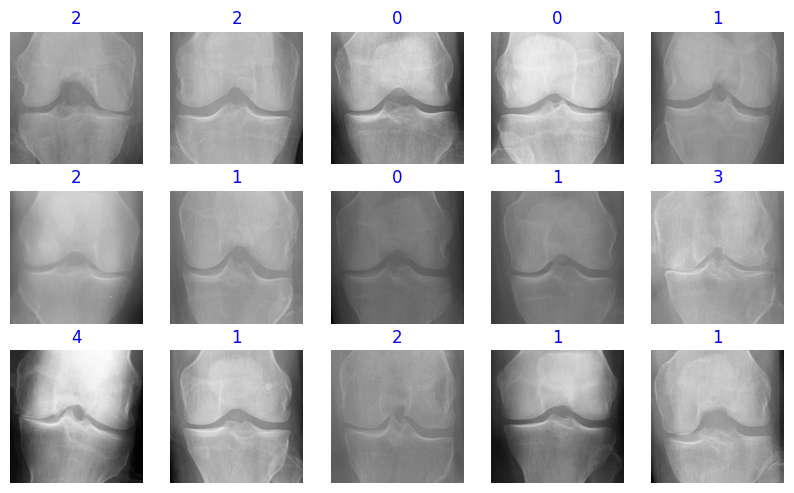

In [ ]:
def show_image_samples(gen):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(10, 10))
    length=len(labels)
    if length<15:   #show maximum of 25 images
        r=length
    else:
        r=15
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()

show_image_samples(test_gen)

In [ ]:
kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

def create_model():
    base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze semua layer kecuali 4 terakhir
    for layer in base_model.layers[:-8]:
        layer.trainable = False
    for layer in base_model.layers[-8:]:
        layer.trainable = True

    x = base_model.output

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = GlobalAveragePooling2D()(x)

    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)

    predictions = Dense(5, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

fold_accuracies = []
histories = []
fold = 1

for train_index, val_index in kf.split(train_df, train_df['labels']):
    print(f'\nTraining Fold {fold}...')

    fold_train_df = train_df.iloc[train_index].reset_index(drop = True)
    fold_valid_df = train_df.iloc[val_index].reset_index(drop = True)

    classes = np.unique(fold_train_df['labels'])
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=fold_train_df['labels'])
    class_weight_dict = dict(zip(classes, class_weights))
    print(f"Class weights (Fold {fold}):", class_weight_dict)

    train_gen = datagen.flow_from_dataframe(
        fold_train_df,
        x_col='filepaths',
        y_col='labels',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    val_gen = valid_generator.flow_from_dataframe(
        fold_valid_df,
        x_col='filepaths',
        y_col='labels',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    model = create_model()

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=20,
        callbacks=[early_stopping, reduce_lr]
    )

    histories.append(history)

    scores = model.evaluate(val_gen, verbose=0)
    print(f"Fold {fold} - Loss: {scores[0]} - Accuracy: {scores[1]*100:.2f}%")

    fold_accuracies.append(scores[1] * 100)
    fold += 1

print('=================================')
print(f'Average accuracy over {k_folds} folds: {np.mean(fold_accuracies):.2f}% (+/- {np.std(fold_accuracies):.2f})')
print('=================================')



Training Fold 1...
Class weights (Fold 1): {'0': np.float64(0.5879835390946502), '1': np.float64(1.2768543342269885), '2': np.float64(0.8771025168815224), '3': np.float64(1.742439024390244), '4': np.float64(1.2467713787085515)}
Found 7144 validated image filenames belonging to 5 classes.
Found 1786 validated image filenames belonging to 5 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 4026s 36s/step - accuracy: 0.3490 - loss: 1.5717 - val_accuracy: 0.2161 - val_loss: 1.5491 - learning_rate: 1.0000e-04
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 65s 581ms/step - accuracy: 0.5165 - loss: 1.1181 - val_accuracy: 0.5358 - val_loss: 1.1046 - learning_rate: 1.0000e-04
Epoch 3/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 64s 568ms/step - accuracy: 0.5783 - loss: 0.9844 - val_accuracy: 0.5829 - val_loss: 0.9553 - learning_rate: 1.0000e-04
Epoch 4/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 84s 586ms/step - accuracy: 0.6187 - loss: 0.8997 - val_accuracy: 0.6657 - val_loss: 0.7875 - learning_rate: 1.0000e-04
Epoch 5/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 63s 562ms/step - accuracy: 0.6520 - loss: 0.8319 - val_accuracy: 0.6781 - val_loss: 0.7666 - learning_rate: 1.0000e-04
Epoch 6/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 84s 581ms/step - accuracy: 0.6611 - loss: 0.8132 - val_accuracy: 0.5756 - val_loss: 0.9666 - learning_rate: 1.0000e-04
Epoch 7/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 63s 56

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 78s 618ms/step - accuracy: 0.3567 - loss: 1.5157 - val_accuracy: 0.5179 - val_loss: 1.1530 - learning_rate: 1.0000e-04
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 64s 570ms/step - accuracy: 0.5062 - loss: 1.1102 - val_accuracy: 0.4423 - val_loss: 1.1701 - learning_rate: 1.0000e-04
Epoch 3/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 63s 565ms/step - accuracy: 0.6164 - loss: 0.9201 - val_accuracy: 0.5375 - val_loss: 1.1321 - learning_rate: 1.0000e-04
Epoch 4/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 64s 567ms/step - accuracy: 0.6528 - loss: 0.8450 - val_accuracy: 0.5974 - val_loss: 1.0858 - learning_rate: 1.0000e-04
Epoch 5/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 64s 570ms/step - accuracy: 0.6469 - loss: 0.8453 - val_accuracy: 0.4961 - val_loss: 1.3583 - learning_rate: 1.0000e-04
Epoch 6/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 65s 574ms/step - accuracy: 0.6732 - loss: 0.7841 - val_accuracy: 0.6865 - val_loss: 0.7355 - learning_rate: 1.0000e-04
Epoch 7/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 64s 57

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 78s 629ms/step - accuracy: 0.3272 - loss: 1.5951 - val_accuracy: 0.2996 - val_loss: 1.4785 - learning_rate: 1.0000e-04
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 65s 577ms/step - accuracy: 0.5279 - loss: 1.1049 - val_accuracy: 0.4418 - val_loss: 1.2614 - learning_rate: 1.0000e-04
Epoch 3/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 81s 570ms/step - accuracy: 0.5889 - loss: 0.9632 - val_accuracy: 0.4838 - val_loss: 1.2293 - learning_rate: 1.0000e-04
Epoch 4/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 64s 573ms/step - accuracy: 0.6286 - loss: 0.8587 - val_accuracy: 0.6137 - val_loss: 0.9941 - learning_rate: 1.0000e-04
Epoch 5/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 81s 569ms/step - accuracy: 0.6745 - loss: 0.7872 - val_accuracy: 0.6131 - val_loss: 0.9939 - learning_rate: 1.0000e-04
Epoch 6/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 63s 563ms/step - accuracy: 0.6756 - loss: 0.7865 - val_accuracy: 0.6562 - val_loss: 0.8194 - learning_rate: 1.0000e-04
Epoch 7/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 64s 56

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 79s 635ms/step - accuracy: 0.3610 - loss: 1.5397 - val_accuracy: 0.3740 - val_loss: 1.3580 - learning_rate: 1.0000e-04
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 64s 572ms/step - accuracy: 0.5223 - loss: 1.1306 - val_accuracy: 0.4518 - val_loss: 1.2923 - learning_rate: 1.0000e-04
Epoch 3/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 64s 571ms/step - accuracy: 0.5857 - loss: 0.9681 - val_accuracy: 0.5241 - val_loss: 1.1858 - learning_rate: 1.0000e-04
Epoch 4/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 83s 579ms/step - accuracy: 0.6293 - loss: 0.8792 - val_accuracy: 0.5381 - val_loss: 1.3155 - learning_rate: 1.0000e-04
Epoch 5/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 63s 565ms/step - accuracy: 0.6517 - loss: 0.8345 - val_accuracy: 0.5459 - val_loss: 1.1139 - learning_rate: 1.0000e-04
Epoch 6/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 63s 561ms/step - accuracy: 0.6815 - loss: 0.7780 - val_accuracy: 0.6876 - val_loss: 0.7473 - learning_rate: 1.0000e-04
Epoch 7/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 64s 56

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 77s 619ms/step - accuracy: 0.3392 - loss: 1.5446 - val_accuracy: 0.3438 - val_loss: 1.5107 - learning_rate: 1.0000e-04
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 64s 572ms/step - accuracy: 0.4967 - loss: 1.1803 - val_accuracy: 0.5274 - val_loss: 1.1578 - learning_rate: 1.0000e-04
Epoch 3/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 63s 565ms/step - accuracy: 0.5707 - loss: 1.0072 - val_accuracy: 0.4664 - val_loss: 1.4265 - learning_rate: 1.0000e-04
Epoch 4/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 64s 570ms/step - accuracy: 0.6135 - loss: 0.9159 - val_accuracy: 0.6562 - val_loss: 0.8318 - learning_rate: 1.0000e-04
Epoch 5/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 63s 565ms/step - accuracy: 0.6351 - loss: 0.8758 - val_accuracy: 0.6557 - val_loss: 0.8301 - learning_rate: 1.0000e-04
Epoch 6/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 64s 567ms/step - accuracy: 0.6554 - loss: 0.8230 - val_accuracy: 0.4731 - val_loss: 1.2686 - learning_rate: 1.0000e-04
Epoch 7/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 64s 56

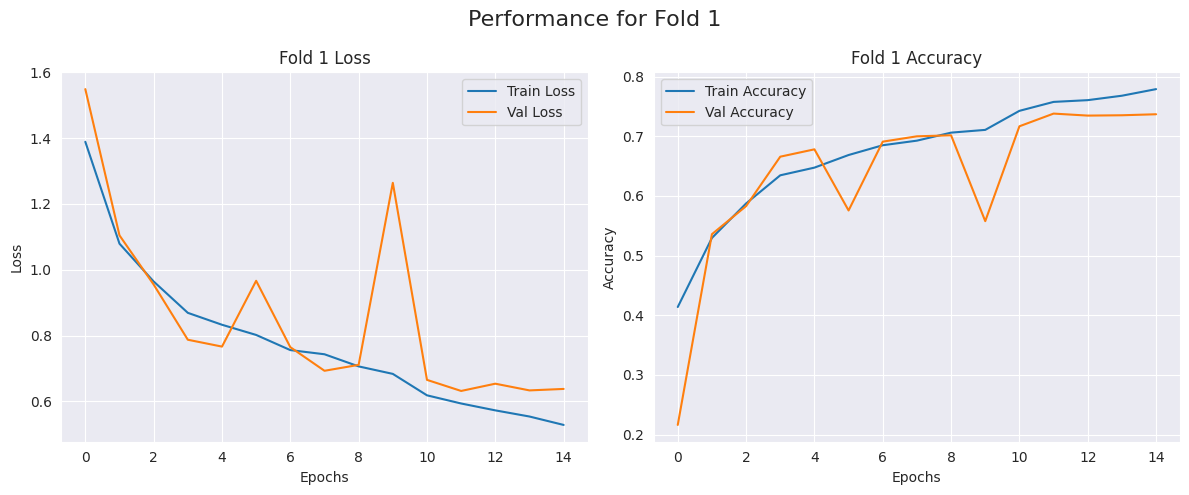

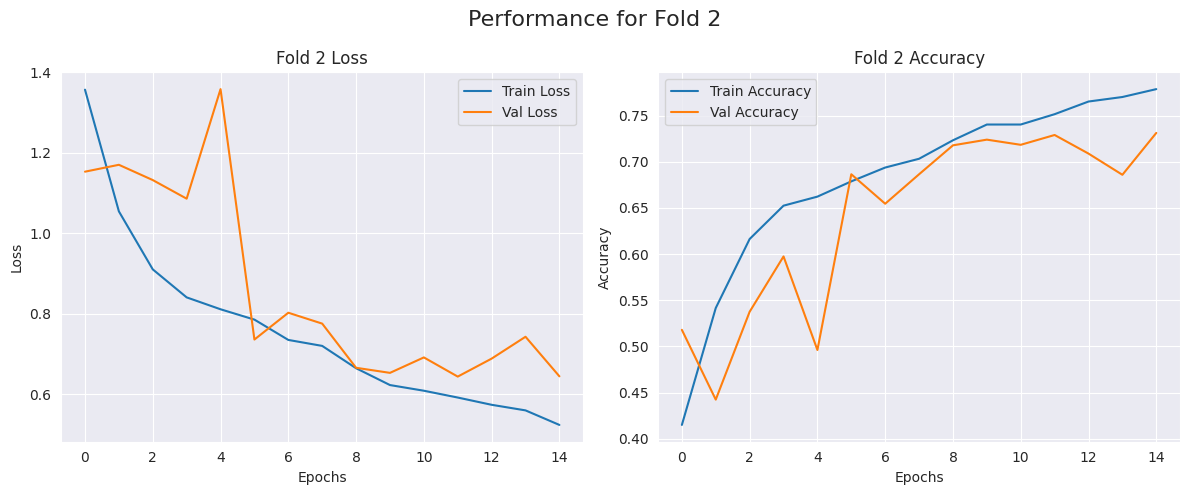

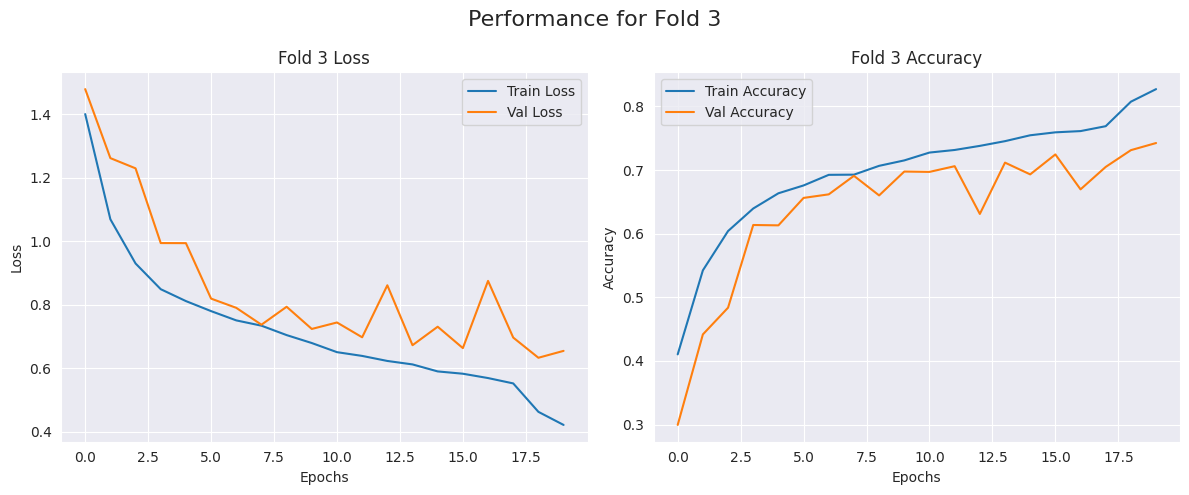

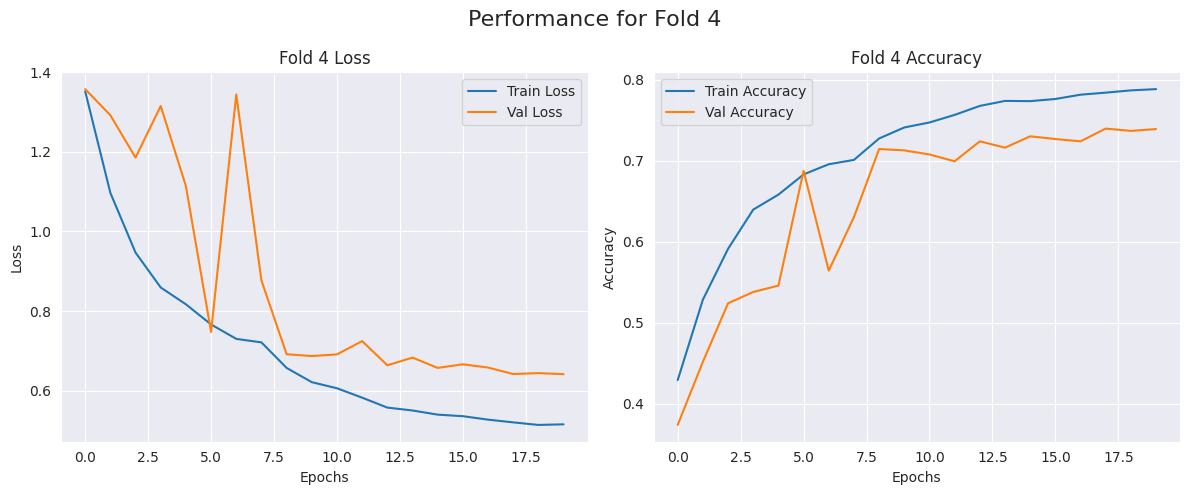

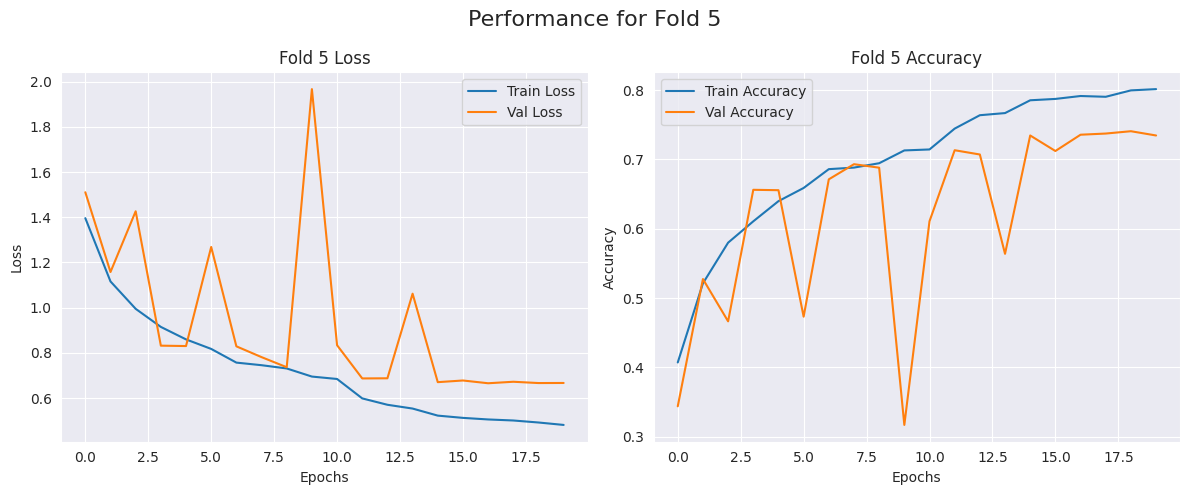

Semua plot selesai!


In [ ]:
for i, history in enumerate(histories, start=1):
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Fold {i} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'Fold {i} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.suptitle(f'Performance for Fold {i}', fontsize=16)
    plt.tight_layout()
    plt.show()  # tampilkan plot fold i

print("Semua plot selesai!")

2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 194ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━

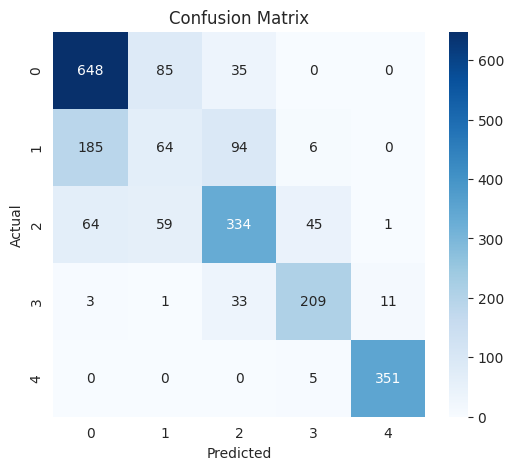

              precision    recall  f1-score   support

           0       0.72      0.84      0.78       768
           1       0.31      0.18      0.23       349
           2       0.67      0.66      0.67       503
           3       0.79      0.81      0.80       257
           4       0.97      0.99      0.98       356

    accuracy                           0.72      2233
   macro avg       0.69      0.70      0.69      2233
weighted avg       0.69      0.72      0.70      2233



In [ ]:
y_true = []
y_pred = []
class_labels = list(test_gen.class_indices.keys())

for _ in range(len(test_gen)):
    x_batch, y_batch = next(test_gen)
    y_true.extend(np.argmax(y_batch, axis=1))  # Label asli
    y_pred.extend(np.argmax(model.predict(x_batch), axis=1))  # Prediksi model

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=class_labels))

In [ ]:
model.save('/content/drive/MyDrive/my_model.h5')